- Listado de 200 palababras mas frecuentes en el dataset (spearadas en preguntas y respuestas)
- Feature engineering, revisar el dataset para encontrar features y sumar embedings


# Reddit Q&A analysis using Transformers, Embeddings, and Feature Engineering

dataset: https://www.kaggle.com/rodmcn/askreddit-questions-and-answers?select=reddit_answers.csv

In [ ]:
!pip install -U spacy==3.1.2
!python -m spacy download en_core_web_sm
!pip install fasttext
!pip install sentence_transformers

In [44]:
import json
import pandas as pd
import numpy as np
import random
import spacy
import re
from tqdm.notebook import tqdm
from google.colab import drive

drive.mount('/content/drive')
pd.set_option('display.max_colwidth', None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
DATASET_PATH = "/content/drive/MyDrive/facu/textmining/"

QUESTIONS_DATASET_FILE = "reddit_questions.csv"
ANSWERS_DATASET_FILE = "reddit_answers.csv"

MAX_ROWS = 10000
NUMBER_OF_ANSWERS = 5566660
QUESTIONS_VOTES_THRESHOLD = 50

In [46]:
df_questions = pd.read_csv(DATASET_PATH + QUESTIONS_DATASET_FILE, error_bad_lines=False, sep=";")
df_questions.set_index("id", inplace = True, drop=False)

skip_lines = sorted(random.sample(range(1, NUMBER_OF_ANSWERS + 1), NUMBER_OF_ANSWERS - MAX_ROWS))
df_answers = pd.read_csv(DATASET_PATH + ANSWERS_DATASET_FILE, error_bad_lines=False, skiprows=skip_lines, sep=";")
df_answers.votes = df_answers.votes.astype("Int64")
df_answers = df_answers[df_answers["votes"] >= QUESTIONS_VOTES_THRESHOLD]

# Explore DataSet

In [68]:
df_questions.head()

,id,text,votes,timestamp,datetime
id,,,,,
izucgz,izucgz,What's the purpose of life?,8,1.601076e+09,Fri Sep 25 23:13:31 2020 UTC
9c784/,9c784/,"I've tried to quit smoking, this is my seventh attempt in the last year. I went 2 weeks, started smoking again. What are your stories Reddit on quitting and not being able to quit?",11,1.250712e+09,Wed Aug 19 19:58:54 2009 UTC
iylxwl,iylxwl,"For those who have a slave master last name, will you change it? And if so, why?",0,1.600904e+09,Wed Sep 23 23:35:15 2020 UTC
gmmlj4,gmmlj4,How do you think humans will become extinct?,21998,1.589887e+09,Tue May 19 11:18:05 2020 UTC
ishb7v,ishb7v,What is a movie So Disturbing you couldn't be paid to see again?,13,1.600074e+09,Mon Sep 14 08:53:53 2020 UTC


In [64]:
df_answers.sample(5)

,id,q_id,text,votes
8909,5117374,dkx72k,"There are 10 kinds of people, those who understand binary, and those who don't.",875
8892,5108351,2yics0,"""""I...die?..."" The Iron Giant. Never have I cried over a robot :( """,276
1857,1052200,84cnia,Microwaves are now illegal in restaurants.,654
9131,5240783,54lfsc,"This guy talking to turkeys. I don't know why, but it gets me every damn time.",1768
1965,1117519,fcdi6a,"I was told about a kid in my nieces nursing program. Kid had a smart watch where he could access data from his phone. Prior to the tests he'd put all of the data he needed where he could scroll through it on his watch. During the final the Teacher asked for all phones to be turned off or you'll get a failing grade. Someone was texting the kid during the exam, the watch the started making noises and the teacher realized he has been cheating all semester long. No idea what happened to the kid. This must have been when the gen1 Apple Watches & Samsung devices came out.",873


In [71]:
df_questions.loc["dkx72k"]["text"]

'What\'s your version of ""there are two kinds of people..""?'

# Importing Spacy

In [49]:
nlp = spacy.load("en_core_web_sm")

In [50]:
doc = nlp("What's the purpose of life?")
print([token.lemma_ for token in doc]) 
print([token.pos_ for token in doc]) 

['what', 'be', 'the', 'purpose', 'of', 'life', '?']
['PRON', 'AUX', 'DET', 'NOUN', 'ADP', 'NOUN', 'PUNCT']


# Importing Transformers model

In [51]:
from sentence_transformers import SentenceTransformer, util
# model = SentenceTransformer('sentence-transformers/paraphrase-xlm-r-multilingual-v1')
model = SentenceTransformer('all-mpnet-base-v2')


In [52]:
#Compute embedding for both
question_embedding = model.encode("What is your favorite icecream?", convert_to_tensor=True)
answer_embedding = model.encode("My favorite icecream is Chocolate and Vainilla", convert_to_tensor=True)

#Compute cosine-similarits
cosine_scores = util.pytorch_cos_sim(question_embedding, answer_embedding)
print(cosine_scores)

tensor([[0.8226]])


# Feature engineeering

In [53]:
def lemmatize(doc):
    doc_list = [token.lemma_.lower() for token in doc if (token.is_alpha or token.pos_ == "NUM") and not token.is_stop]
    text_lemmatized = " ".join(doc_list)
    return text_lemmatized

def has_num(doc):
    return any([token.pos_ == "NUM" for token in doc])

def calculate_similarity(question, answer):
    try:
        question_embedding = model.encode(question, convert_to_tensor=True)
        answer_embedding = model.encode(answer, convert_to_tensor=True)
        return util.pytorch_cos_sim(question_embedding, answer_embedding).item()
    except:
        return 0

def build_features(question, answer):
    question_doc = nlp(question)
    answer_doc = nlp(answer)
    question_lemmatized = [token.lemma_.lower() for token in question_doc if not token.is_stop]
    answer_lemmatized = [token.lemma_.lower() for token in answer_doc if not token.is_stop]
    
    # Features
    lemmatized_words_in_common = len(set(question_lemmatized).intersection(set(answer_lemmatized)))
    
    question_lower_case = question.lower()
    is_quantity_question = ("how many" in question_lower_case or "how much" in question_lower_case) and has_num(answer_doc)
    
    qa_similarity = calculate_similarity(question, answer)

    qa_lemma_similarity = calculate_similarity(" ".join(question_lemmatized), " ".join(answer_lemmatized))
    
    return [
        question,
        answer,
        lemmatized_words_in_common,
        is_quantity_question,
        qa_similarity,
        qa_lemma_similarity
    ]


## Build correct answers

In [54]:
questions_answers = []

# Add positive answers
set_indexs = set(df_questions.index)
iter_answers = list(df_answers.iterrows())
for _, answer in tqdm(iter_answers):
    if answer.q_id not in set_indexs:
        continue
    question_row = df_questions.loc[answer.q_id]
    question_text = question_row["text"]
    answer_text = answer["text"]
    questions_answers.append([*build_features(question_text, answer_text), True])

  0%|          | 0/1545 [00:00<?, ?it/s]

## Build incorrect answers

In [55]:
# Add negatives answers
negatives_questions_added = 0
while negatives_questions_added < len(iter_answers):
    random_question = df_questions.sample(1).iloc[0]
    random_answer = df_answers.sample(1).iloc[0]
    if random_answer.q_id == random_question.id:
        continue
    question_text = random_question["text"]
    answer_text = random_answer["text"]
    questions_answers.append([*build_features(question_text, answer_text), False])
    negatives_questions_added += 1


## Build DataSet

In [79]:
columns = [
    "question_text", 
    "answer_text",
    "lemmatized_words_in_common", 
    "is_quantity_question",
    "qa_similarity",
    "qa_lemma_similarity",
    "is_answer"
]

df = pd.DataFrame(questions_answers, columns=columns)


In [98]:
df[~df.is_answer].sample(3)

,question_text,answer_text,lemmatized_words_in_common,is_quantity_question,qa_similarity,qa_lemma_similarity,is_answer
1887,What's a video you've saved on YouTube because its too dam good?,In Vino Veritas. One of very few i know...,0,False,0.166997,0.061327,False
2820,What was your initial reaction to puberty?,"American here, no one fucking eats spam except for Hawaiians for the most part.",0,False,-0.051318,-0.024875,False
1727,What was the most f**ked up song you ever heard?,The Cincinnati Red Stockings' 130 game winning streak. Because there's more than one professional baseball team now.,0,False,0.125516,-0.012588,False


In [95]:
df[df.is_answer].sample(3)

,question_text,answer_text,lemmatized_words_in_common,is_quantity_question,qa_similarity,qa_lemma_similarity,is_answer
426,"As a person that would consider themselves technologically inclined. What is your biggest """"Wow, I'm an idiot"""" Moment?","""When I first got a wifi card for my laptop I said ""Wow! I can listen to the radio without any wires now!"" to my gf, who laughed at me. """,4,False,0.457249,0.256770,True
1056,Money is no object. How do you (legally) ruin your worst enemy's life?,"Buy his job and fire him. Continuously financially bankrupt him, his extended family and closest friends for years, until they all are forced to live in trailer parks or the ghetto. Then give him a million dollars and let all of his friends and family know he has it. They'll tear him apart to get ahead.",1,False,0.578599,0.297708,True
482,"What myths about health/body are people the most stubborn about holding on too, despite the lack of any evidence to support them?",Death by fan. I want the wind on my face damn it.,0,False,0.138885,0.060882,True


# Selecting Feature

In [57]:
#split dataset in features and target variable

feature_cols = [
    "lemmatized_words_in_common", 
    "is_quantity_question",
    "qa_similarity",
    "qa_lemma_similarity",
]

X = df[feature_cols]    # Features
y = df.is_answer        # Target variable

# Splitting Data

In [78]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state=0)

# Model Development and Prediction

In [59]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)

## Metrics

In [60]:
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[336,  32],
       [ 63, 342]])

Text(0.5, 257.44, 'Predicted label')

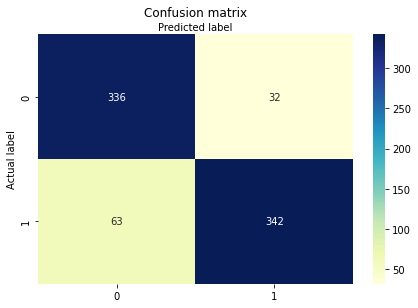

In [77]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


In [75]:
print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred)}")
print(f"Precision: {metrics.precision_score(y_test, y_pred)}")
print(f"Recall: {metrics.recall_score(y_test, y_pred)}")

Accuracy: 0.8771021992238034
Precision: 0.9144385026737968
Recall: 0.8444444444444444
